## Import modules

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import openpyxl

# Note, if you see the message that some module wasn't found, type 
# conda install module_name
# for example, conda install openpyxl
# in the command shell of your OS

/home/vova/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# 1. Reading file with data 'Data for Data Scientist.xlsx'

In [2]:
wb = openpyxl.load_workbook('Data for Data Scientist.xlsx')
sheet = wb.get_sheet_by_name('Value by Year')

# Replace months names into its number
MONTHS = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

miss_rows = 14
transition_years = []
transition_months = []

for row_num, row in enumerate(sheet.iter_rows(row_offset=miss_rows)):
    if row_num == 0: # year row
        for index, cell in enumerate(row):
            if index > 3: 
                transition_years.append(int(cell.value))
    elif row_num == 1: # month row
        for index, cell in enumerate(row):
            if index > 3:
                transition_months.append(MONTHS[cell.value])
        transition_dates_amount = len(transition_months)
        df = pd.DataFrame(columns=['AccountID', 'Industry', 'TransitionYear', 'TransitionMonth', 'Value'])
    else: # transition activity for various accounts
        values = []
        for index, cell in enumerate(row):
            if index == 0:
                account_id = int(cell.value)
            elif index in (1,2):
                pass
            elif index == 3:
                industry = cell.value
            else:
                values.append(cell.value)
        if account_id > 140:
            break
        row_df = pd.DataFrame(
            data={ 
                'AccountID':       [account_id]*transition_dates_amount, 
                'Industry':        [industry]*transition_dates_amount,
                'TransitionYear':  transition_years,
                'TransitionMonth': transition_months,
                'Value':           values
            }
        )
        df = df.append(row_df)
        #print row_num, df.shape
print "DataFrame shape:", df.shape

DataFrame shape: (7030, 5)


/home/vova/anaconda2/lib/python2.7/site-packages/openpyxl/workbook/names/named_range.py:124: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


Display DataFrame (table) content

In [3]:
# Show the first 10 rows for AccountID == 140
df[df['AccountID'] == 140].head(10)

,AccountID,Industry,TransitionMonth,TransitionYear,Value
0,140,Other,7,2008,NaN
1,140,Other,8,2008,NaN
2,140,Other,9,2008,NaN
3,140,Other,10,2008,NaN
4,140,Other,11,2008,NaN
5,140,Other,12,2008,1
6,140,Other,1,2009,958
7,140,Other,2,2009,46
8,140,Other,3,2009,906
9,140,Other,4,2009,208


# 2. Calculate LTV (a relatively simple approach) 

### Total revenue by years

In [4]:
total_revenue = df.groupby('TransitionYear')['Value'].sum()
total_revenue

TransitionYear
2008     8401
2009    29270
2010    32111
2011    43982
2012    48157
2013    51276
2014    57372
2015    53858
2016    23871
Name: Value, dtype: float64

### Accounts active in each year

In [5]:
active_accounts = {year: df[(df['TransitionYear'] == year) & (df['Value'] != 0) & (pd.notnull(df['Value']))]['AccountID'].drop_duplicates().values 
                   for year in range(2008, 2017)}

# New active costumers comparing with the previous year 
# (may contain those persons who has already been a costumer, but who was not active one year or more before)
new_active_accounts = {
    year: df[(df['TransitionYear'] == year) & (df['Value'] != 0) & (pd.notnull(df['Value'])) & (~df['AccountID'].isin(active_accounts[year-1]))] \
          ['AccountID'].drop_duplicates().values 
    for year in range(2009, 2017)}
new_active_accounts.update({ 2008: [] })

# New active costumers who join first time
def join_sets(year):
    res = set()
    for i in range(2008, year):
        res = res | set(active_accounts[i])
    return res

# Accounts joined first time (and wich were not active anywhere previously)
pure_active_accounts = {
    year: df[(df['TransitionYear'] == year) & (df['Value'] != 0) & (pd.notnull(df['Value'])) & (~df['AccountID'].isin(join_sets(year)))] \
          ['AccountID'].drop_duplicates().values 
    for year in range(2009, 2017)}
pure_active_accounts.update({ 2008: [] })

# How many accounts became not active
gone_active_accounts = {
    year: list(set(active_accounts[year-1]) - set(active_accounts[year])) for year in range(2009, 2017)}
gone_active_accounts.update({ 2008: [] })

Display calculated values in the bar chart

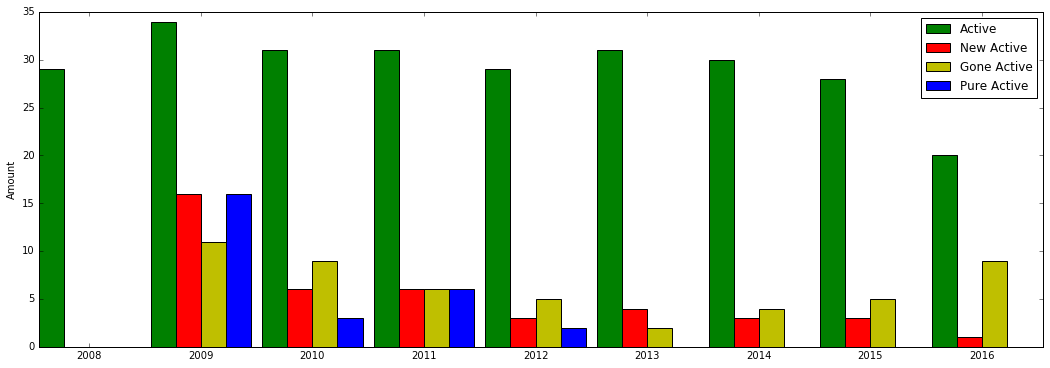

In [6]:
def get_amount(dictionary):
    keys = sorted(dictionary.keys())
    return [len(dictionary[key]) for key in keys]

N = len(range(2008, 2017))
ind = np.arange(N)
width = 0.225

fig, ax = plt.subplots(figsize=(18, 6))
active = ax.bar(ind, get_amount(active_accounts), width, color='g')
new_active = ax.bar(ind + width, get_amount(new_active_accounts), width, color='r')
gone_active = ax.bar(ind + 2*width, get_amount(gone_active_accounts), width, color='y')
pure_active = ax.bar(ind + 3*width, get_amount(pure_active_accounts), width, color='b')

ax.set_ylabel('Amount')
ax.set_xticks(ind + 2*width)
ax.set_xticklabels(sorted(active_accounts.keys()))

ax.legend((active[0], new_active[0], gone_active[0], pure_active[0]), ('Active', 'New Active', 'Gone Active', 'Pure Active'))
plt.show()

## Calculation for LTV

#### 2.1. Customer Retention Rate (CRR):
$$CRR = ((E-N)/S)*100,$$

where 

* $E$ is the number of customers at the end of a period;
* $N$ is the number of new customers acquired during that period;
* $S$ is the number of customers at the start of that period.

In [7]:
E = {year: len(df[(df['TransitionYear'] == year) & (df['Value'] != 0) & (pd.notnull(df['Value']))]['AccountID'].drop_duplicates().values) 
                   for year in range(2008, 2017)}

print "Number of customers at the end of a period:\n", E

N = {
    year: len(df[(df['TransitionYear'] == year) & (df['Value'] != 0) & (pd.notnull(df['Value'])) & (~df['AccountID'].isin(active_accounts[year-1]))] \
          ['AccountID'].drop_duplicates().values)
    for year in range(2009, 2017)}
N.update({ 2008: 0 })

print
print "Number of new customers acquired during that period:\n", N

S = {year: len(df[(df['TransitionYear'] == year-1) & (df['Value'] != 0) & (pd.notnull(df['Value']))]['AccountID'].drop_duplicates().values) 
                   for year in range(2009, 2017)}

S.update({ 2008: len(df[(df['TransitionYear'] == 2008) & (df['TransitionMonth'] == 8) & (df['Value'] != 0) &
                        (pd.notnull(df['Value']))]['AccountID'].drop_duplicates().values) 
         })

print
print "Number of customers at the start of that period:\n", S

CRR = {}
for year in range(2008, 2017):
    CRR.update({year: (E[year] - N[year])/float(S[year])})
    
print
print "CRR:", CRR

Number of customers at the end of a period:
{2016: 20, 2008: 29, 2009: 34, 2010: 31, 2011: 31, 2012: 29, 2013: 31, 2014: 30, 2015: 28}

Number of new customers acquired during that period:
{2016: 1, 2008: 0, 2009: 16, 2010: 6, 2011: 6, 2012: 3, 2013: 4, 2014: 3, 2015: 3}

Number of customers at the start of that period:
{2016: 28, 2008: 10, 2009: 29, 2010: 34, 2011: 31, 2012: 31, 2013: 29, 2014: 31, 2015: 30}

CRR: {2016: 0.6785714285714286, 2008: 2.9, 2009: 0.6206896551724138, 2010: 0.7352941176470589, 2011: 0.8064516129032258, 2012: 0.8387096774193549, 2013: 0.9310344827586207, 2014: 0.8709677419354839, 2015: 0.8333333333333334}


#### 2.2. Customer profit for each industry:

In [8]:
industries = df['Industry'].drop_duplicates().values
print "Industries:", industries

ind_profit = {ind: {} for ind in industries}
for year in range(2008,2017):
    for ind in industries:
        x = df[(df['TransitionYear'] == year) & (df['Industry'] == ind)]['Value'].sum()
        ind_profit[ind].update({ year: 0 if np.isnan(x) else x })
        
print "Total profit:\n", ind_profit

Industries: [u'Other' u'S' u'M' u'EO' u'D' u'SC' u'G' u'C' u'T']
Total profit:
{u'EO': {2016: 0.0, 2008: 846.0, 2009: 420.0, 2010: 1055.0, 2011: 854.0, 2012: 841.0, 2013: 966.0, 2014: 516.0, 2015: 517.0}, u'D': {2016: 1379.0, 2008: 262.0, 2009: 1759.0, 2010: 1155.0, 2011: 2124.0, 2012: 2092.0, 2013: 1670.0, 2014: 2181.0, 2015: 1693.0}, u'G': {2016: 0.0, 2008: 0.0, 2009: 554.0, 2010: 337.0, 2011: 589.0, 2012: 559.0, 2013: 667.0, 2014: 592.0, 2015: 0.0}, u'M': {2016: 0.0, 2008: 0.0, 2009: 0.0, 2010: 99.0, 2011: 122.0, 2012: 235.0, 2013: 102.0, 2014: 162.0, 2015: 40.0}, u'C': {2016: 0.0, 2008: 18.0, 2009: 144.0, 2010: 474.0, 2011: 91.0, 2012: 161.0, 2013: 21.0, 2014: 452.0, 2015: 121.0}, u'S': {2016: 14101.0, 2008: 5642.0, 2009: 15744.0, 2010: 19283.0, 2011: 27614.0, 2012: 24515.0, 2013: 31519.0, 2014: 31751.0, 2015: 33261.0}, u'Other': {2016: 5374.0, 2008: 895.0, 2009: 7762.0, 2010: 7258.0, 2011: 9063.0, 2012: 14761.0, 2013: 12103.0, 2014: 17103.0, 2015: 12497.0}, u'T': {2016: 934.0, 200

Display total profit for each industry

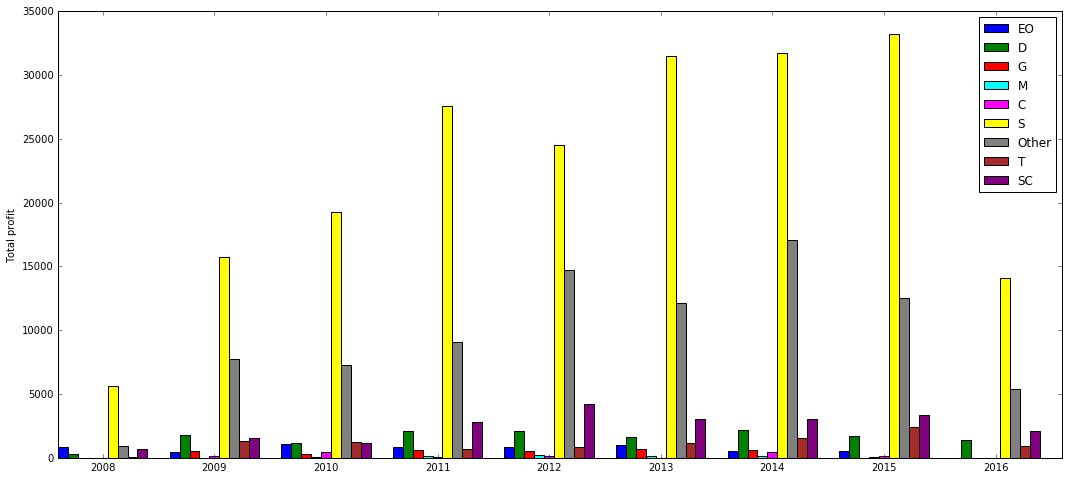

In [9]:
def get_vals(dictionary):
    keys = sorted(dictionary.keys())
    return [dictionary[key] for key in keys]

N = len(range(2008, 2017))
k = len(industries)
ind = np.arange(N)
width = 0.8/k
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'grey', 'brown', 'purple']

fig, ax = plt.subplots(figsize=(18, 8))
charts = []
c = 0
ind_names = []
for key, val in ind_profit.iteritems():
    chart = ax.bar(ind + c*width, get_vals(val), width, color=colors[c])
    charts.append(chart)
    ind_names.append(key)
    c += 1

ax.set_ylabel('Total profit')
ax.set_xticks(ind + (N/2.)*width)
ax.set_xticklabels(range(2008,2017))

ax.legend((i[0] for i in charts), (ind_names))
plt.show()

#### 2.3. Calculate LTV:
We will use the two approaches

1) $$LTV = \sum_{t=1}^n <r>^t\cdot\frac{P_t}{(1+d)^t};$$

2) $$LTV = \sum_{t=1}^n r_t^t\cdot\frac{P_t}{(1+d)^t},$$

where

* $t$ is a period, e.g. the first year(t=1), the second year(t=2)
* $n$ is the total number of periods the customer will stay before he/she finally churns
* $r_t$ is the retention rate/possibility for the period t
* $<r>$ is the average retention rate
* $P_t$ is the profit the customer will contribute in the Period t
* $d$ is the discount rate

In [10]:
CRR_avg = np.mean(list(CRR[year] for year in range(2009, 2017)))
CRR_avg

0.78938150621761494

#### The second formula

In [11]:
d = 0.1

LTV2 = {}
for ind in industries:
    LTV2.update({ 
        ind: round(sum(CRR[year]**(i+1) * ind_profit[ind][year]/(1+d)**(i+1) for i, year in enumerate(range(2009, 2017))), 2) 
    })
    
print "LTV:"
LTV2

LTV:


{u'C': 521.15,
 u'D': 4586.83,
 u'EO': 1949.94,
 u'G': 1319.81,
 u'M': 261.69,
 u'Other': 27556.94,
 u'S': 63240.54,
 u'SC': 6538.79,
 u'T': 3118.94}

#### The first formula:

In [12]:
d = 0.1

LTV1 = {}
for ind in industries:
    LTV1.update({ 
        ind: round(sum(CRR_avg**(i+1) * ind_profit[ind][year]/(1+d)**(i+1) for i, year in enumerate(range(2009, 2017))), 2) 
    })
    
print "LTV:"
LTV1

LTV:


{u'C': 501.35,
 u'D': 4075.44,
 u'EO': 1688.32,
 u'G': 1144.82,
 u'M': 203.85,
 u'Other': 22813.78,
 u'S': 52521.37,
 u'SC': 5360.17,
 u'T': 2808.75}

Let's visualize

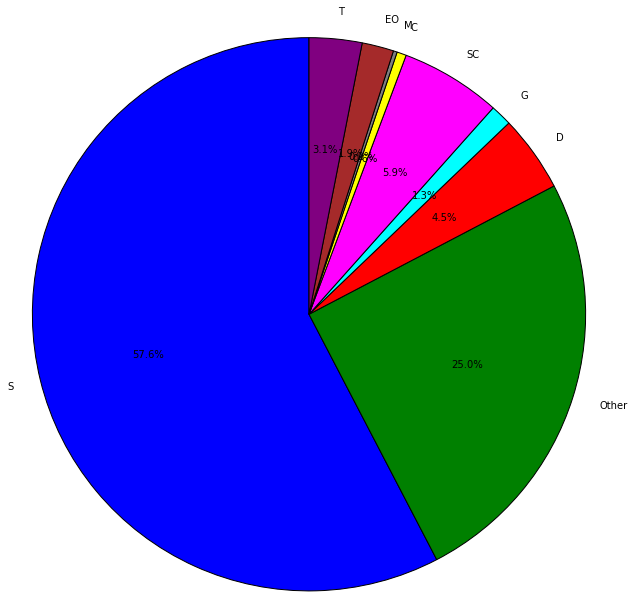

In [13]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'grey', 'brown', 'purple']

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(LTV1.values(), labels=LTV1.keys(), colors=colors, startangle=90, autopct='%1.1f%%')
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

The same but year by year dynamics:

In [14]:
d = 0.1

LTV = {}
for i, year in enumerate(range(2009, 2017)):
    crr = np.mean(list(CRR[n] for n in range(2009, year+1)))
    LTV.update({year: {}})
    for ind in industries:
        LTV[year].update({ 
            ind: round( sum(crr**(i+1) * ind_profit[ind][year]/(1+d)**(i+1)
                        for n in range(2009, year+1)
                      ), 2) 
        })
    
print "LTV:"
LTV

LTV:


{2009: {u'C': 81.25,
  u'D': 992.54,
  u'EO': 236.99,
  u'G': 312.6,
  u'M': 0.0,
  u'Other': 4379.81,
  u'S': 8883.76,
  u'SC': 882.51,
  u'T': 746.52},
 2010: {u'C': 360.14,
  u'D': 877.56,
  u'EO': 801.58,
  u'G': 256.05,
  u'M': 75.22,
  u'Other': 5514.56,
  u'S': 14651.03,
  u'SC': 903.39,
  u'T': 958.1},
 2011: {u'C': 76.82,
  u'D': 1792.93,
  u'EO': 720.89,
  u'G': 497.19,
  u'M': 102.98,
  u'Other': 7650.34,
  u'S': 23309.78,
  u'SC': 2387.2,
  u'T': 588.36},
 2012: {u'C': 139.39,
  u'D': 1811.17,
  u'EO': 728.1,
  u'G': 483.96,
  u'M': 203.45,
  u'Other': 12779.48,
  u'S': 21224.09,
  u'SC': 3623.2,
  u'T': 699.53},
 2013: {u'C': 19.61,
  u'D': 1559.7,
  u'EO': 902.19,
  u'G': 622.94,
  u'M': 95.26,
  u'Other': 11303.59,
  u'S': 29437.14,
  u'SC': 2833.6,
  u'T': 1115.14},
 2014: {u'C': 402.89,
  u'D': 1944.01,
  u'EO': 459.93,
  u'G': 527.67,
  u'M': 144.4,
  u'Other': 15244.58,
  u'S': 28300.91,
  u'SC': 2733.74,
  u'T': 1379.79},
 2015: {u'C': 95.39,
  u'D': 1334.68,
  u'EO

Let's visualize this results

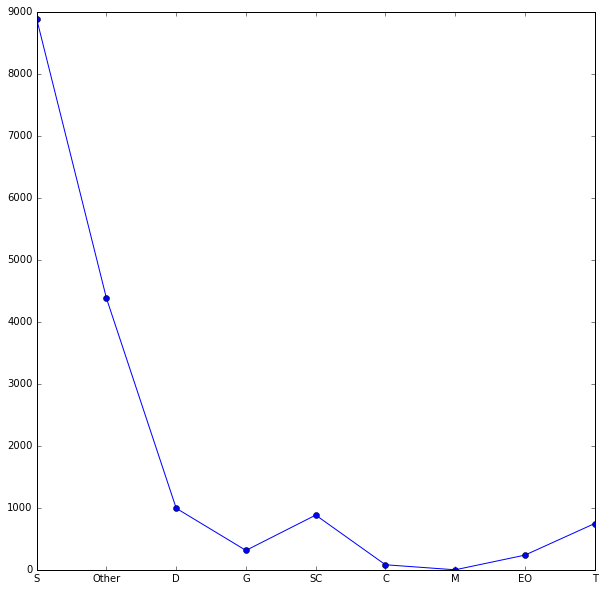

In [15]:
# Type here the year which you want to see the values of LTV for each industry
year = 2009

try:
    labels = []
    vals = []
    for k,v in LTV[year].iteritems():
        labels.append(k)
        vals.append(v)

    n = np.arange(0, len(industries))
    plt.plot(n, vals, 'o-')
    plt.xticks(n, labels)
    plt.show()
except:
    print "Year lies between 2009 and 2016"

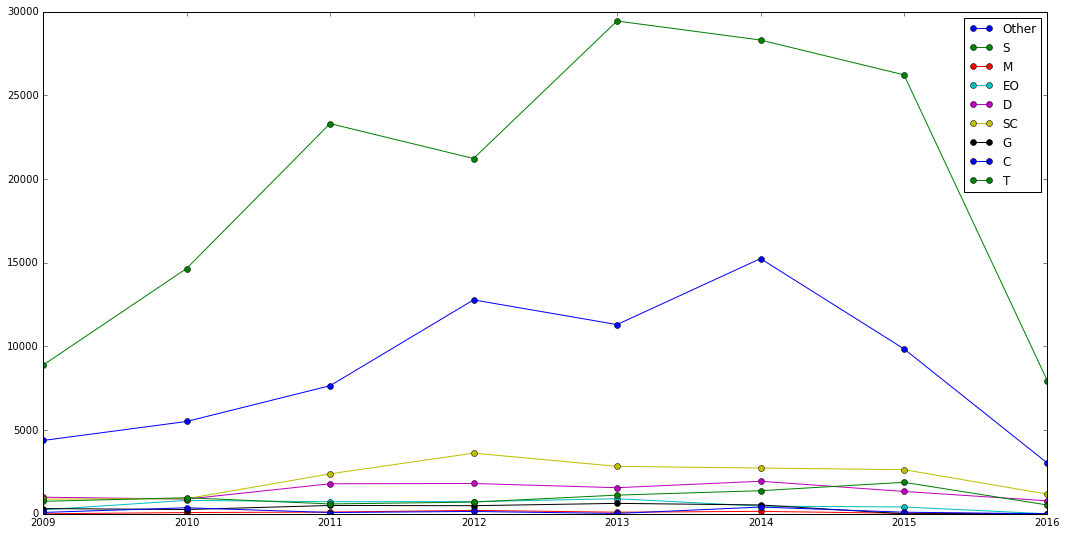

In [16]:
fig, ax = plt.subplots(figsize=(18, 9))
lines = []
labels = list(range(2009, 2017))
n = np.arange(0, len(labels))
for ind in industries:
    vals = []
    for k in sorted(LTV.keys()):
        for k1,v1 in LTV[k].iteritems():
            if k1 == ind:
                vals.append(v1)
    ax1 = ax.plot(n, vals, 'o-')
    lines.append(ax1)
    
plt.xticks(n, labels)    
ax.legend((i[0] for i in lines), list(industries))
plt.show()

# 3. Convert to frequency/ recency and another approach to calculation of LTV (more complicated)

Import a new helpfull library

In [17]:
# You need install lifetimes Python library
# Type "conda install lifetimes" (without quotes) in the terminal or command line

from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import GammaGammaFitter, BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_history_alive

Transform year and month to datetime format and remain only not-null records

In [18]:
df_date = df.copy()
df_date = df_date[(df['Value'] != 0) & (pd.notnull(df['Value']))]
df_date['TransitionDate'] = df_date.apply(
    lambda x: datetime.datetime.strptime(str(int(x['TransitionYear'])) + str(int(x['TransitionMonth'])) + '1', "%Y%m%d").date(), 
    axis=1)
df_date.drop(['TransitionYear', 'TransitionMonth'], axis=1, inplace=True)
df_date[df_date['AccountID'] == 140].head(5)

,AccountID,Industry,Value,TransitionDate
5,140,Other,1,2008-12-01
6,140,Other,958,2009-01-01
7,140,Other,46,2009-02-01
8,140,Other,906,2009-03-01
9,140,Other,208,2009-04-01


#### Crate a new table with the following columns:

* ***frequency*** represents the number of repeat purchases the customer has made. 

* ***T*** represents the age of the customer in whatever time units chosen. This is equal to the duration between a customer's first purchase and the end of the period under study (below we use months and years for more fine analysis).

* ***recency*** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer's first purchase and their latest purchase.

In [19]:
summary_m = summary_data_from_transaction_data(
    df_date, 
    customer_id_col='AccountID', 
    datetime_col='TransitionDate',
    monetary_value_col='Value',
    freq='M'                            
)

print summary_m.shape
summary_m.head()

(56, 4)


,frequency,recency,T,monetary_value
AccountID,,,,
1,75,94,95,49.266667
6,63,94,95,181.682540
8,1,1,88,270.000000
10,1,1,95,157.000000
11,70,78,79,240.400000


In [20]:
summary_y = summary_data_from_transaction_data(
    df_date, 
    customer_id_col='AccountID', 
    datetime_col='TransitionDate',
    monetary_value_col='Value',
    freq='Y'                            
)

print summary_y.shape
summary_y.head()

/home/vova/anaconda2/lib/python2.7/site-packages/lifetimes/utils.py:149: FutureWarning: Freq "Y" is deprecated, use "A" as alternative.
  observation_period_end = pd.to_datetime(observation_period_end, format=datetime_format).to_period(freq)
/home/vova/anaconda2/lib/python2.7/site-packages/pandas/tseries/period.py:55: FutureWarning: Freq "Y" is deprecated, use "A" as alternative.
  base, mult = _gfc(freq)


(56, 4)


,frequency,recency,T,monetary_value
AccountID,,,,
1,8,8,8,461.125000
6,8,8,8,1274.125000
8,0,0,7,0.000000
10,0,0,8,0.000000
11,7,7,7,2385.571429


Remain only those records where frequency > 0

In [21]:
returning_summary_m = summary_m[summary_m['frequency']>0]
returning_summary_y = summary_y[summary_y['frequency']>0]

print "returning_summary_m.shape:", returning_summary_m.shape
print "returning_summary_y.shape:", returning_summary_y.shape
returning_summary_m.head()

returning_summary_m.shape: (53, 4)
returning_summary_y.shape: (42, 4)


,frequency,recency,T,monetary_value
AccountID,,,,
1,75,94,95,49.266667
6,63,94,95,181.682540
8,1,1,88,270.000000
10,1,1,95,157.000000
11,70,78,79,240.400000


The model we are going to use now to estimate the LTV is the Gamma-Gamma submodel (some info can be found [here](http://www.brucehardie.com/notes/025/gamma_gamma.pdf) and [here](http://www.brucehardie.com/papers/rfm_clv_2005-02-16.pdf)), which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [22]:
print "Months:"
print returning_summary_m[['monetary_value', 'frequency']].corr()

print "\nYears:"
print returning_summary_y[['monetary_value', 'frequency']].corr()

Months:
                monetary_value  frequency
monetary_value        1.000000   0.288765
frequency             0.288765   1.000000

Years:
                monetary_value  frequency
monetary_value        1.000000   0.481055
frequency             0.481055   1.000000


As we can see for annually processed data correlation is too high, that's why we consider only `returning_summary_m` and display the computed conditional expectation of the average profit per transaction for a group of one or more customers

In [23]:
ggf = GammaGammaFitter()
ggf.fit(returning_summary_m['frequency'], returning_summary_m['monetary_value'])   

ggf.conditional_expected_average_profit(summary_m['frequency'], summary_m['monetary_value']).head(10)

AccountID
1      51.744819
6     182.529547
8     252.486750
10    196.354834
11    240.325817
13    166.690585
14    272.677176
16     52.031709
17     88.707155
19     44.667476
dtype: float64

We'll use the BG/NBD model to calculate the LTV value (more info [here](http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf))

In [24]:
bgf = BetaGeoFitter()

# fit the BG model to the summary_with_money_value dataset
bgf.fit(summary_m['frequency'], summary_m['recency'], summary_m['T'])

CLV = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_m['frequency'],
    summary_m['recency'],
    summary_m['T'],
    summary_m['monetary_value'],
    time=12, # months
    discount_rate=0.7
)
CLV.head(10)

AccountID
1     1637.436025
6     4866.540349
8        0.826135
10       0.503361
11    8432.144425
13    2272.696429
14      46.950930
16     486.805046
17       0.066078
19    1073.277636
Name: clv, dtype: float64

Thus we calculate the CLV for each account.

## Calculate CLV for each industry

At first find which AccountIDs corresponds to which industry category

In [25]:
customers = {}
for ind in industries:
    customers.update({ ind: np.unique(df_date[df_date['Industry'] == ind]['AccountID'].values) })
customers

{u'C': array([  49.,  132.]),
 u'D': array([  19.,   22.,  115.,  116.]),
 u'EO': array([  17.,   96.,  108.,  109.]),
 u'G': array([  43.,   94.,  137.]),
 u'M': array([ 16.]),
 u'Other': array([   1.,   10.,   25.,   38.,   66.,   73.,   92.,   98.,  104.,
         112.,  119.,  123.,  129.,  138.,  139.,  140.]),
 u'S': array([   6.,    8.,   11.,   13.,   14.,   32.,   34.,   36.,   39.,
          41.,   53.,   57.,   63.,   65.,   70.,   74.,   76.,   78.,
          86.,  102.,  114.,  121.]),
 u'SC': array([ 28.,  89.]),
 u'T': array([  82.,  125.])}

Calculate the total CLV for each industry

In [26]:
industry_LTV = {
    industry: round(sum([CLV[CLV.index == int(ac_id)].values[0] for ac_id in ac_ids]), 2) for industry, ac_ids in customers.iteritems() 
}
industry_LTV

{u'C': 825.4,
 u'D': 6875.19,
 u'EO': 1038.92,
 u'G': 361.31,
 u'M': 486.81,
 u'Other': 35228.65,
 u'S': 84765.8,
 u'SC': 9822.96,
 u'T': 4276.9}

Thus, we get CLV close to obtained before, but the last approach gives more realistic results.

### Add some visualiztions:

#### a)  the Frequency/Recency matrix
Suppose a customer bought from you every week for a few months straight, and we haven't heard from them in years. What are the chances they are still "alive"? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the Frequency/Recency matrix, which computes the expected number of transactions a artifical customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

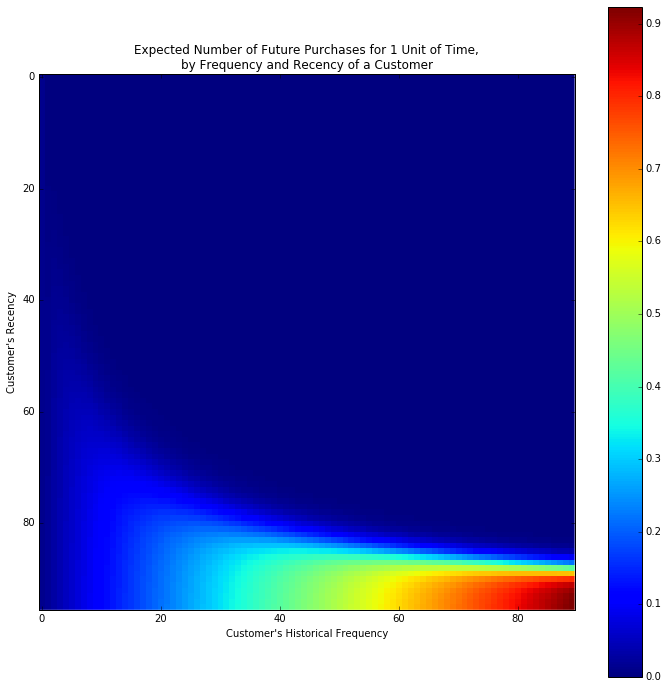

In [27]:
plt.rcParams['figure.figsize'] = (12, 12)
plot_frequency_recency_matrix(bgf)
plt.show()

**What we see:**

If a customer has bought about 70-90 times from you, and their lastest purchase was when they were about 85 weeks old, then they are your best customer (bottom-right). You coldest customers are those that in the top-right corner: they bought a lot quickly, and we haven't seen them in weeks.

There's also that beautiful "tail" around (30,85). That represents the customer who buys infrequently, but we've seen him or her recently, so they might buy again - we're not sure if they are dead or just between purchases.

#### b) Customer transaction history

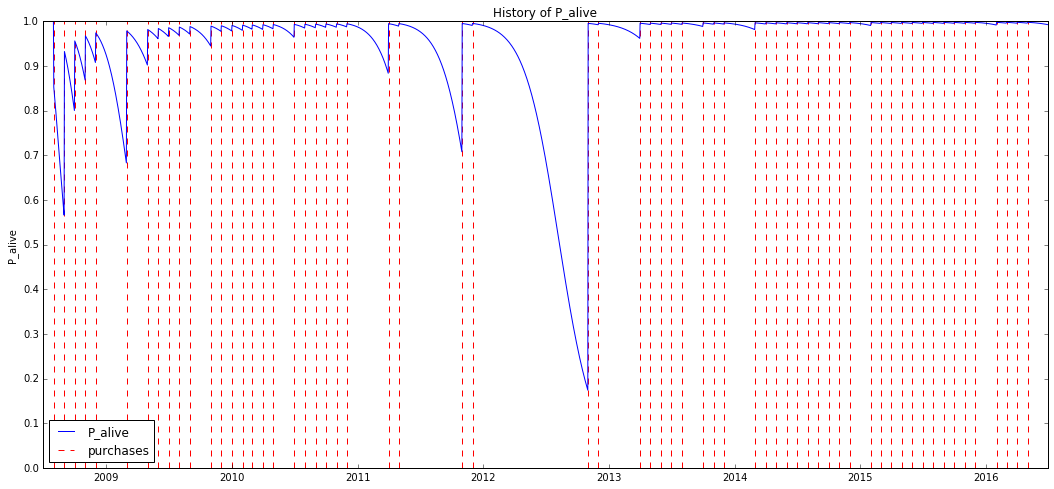

In [28]:
plt.rcParams['figure.figsize'] = (18, 8)

# Replace the AccountID the dynamic of activity of which you want to see
id = 6
try:
    days_since_birth = 365*8
    sp_trans = df_date.ix[df_date['AccountID'] == id]
    plot_history_alive(bgf, days_since_birth, sp_trans, 'TransitionDate')
    plt.show()
except:
    print "AccountID was not found"

# 4. Clusterization of AccountIDs by its activity (frequency and recency)

bestK: 4


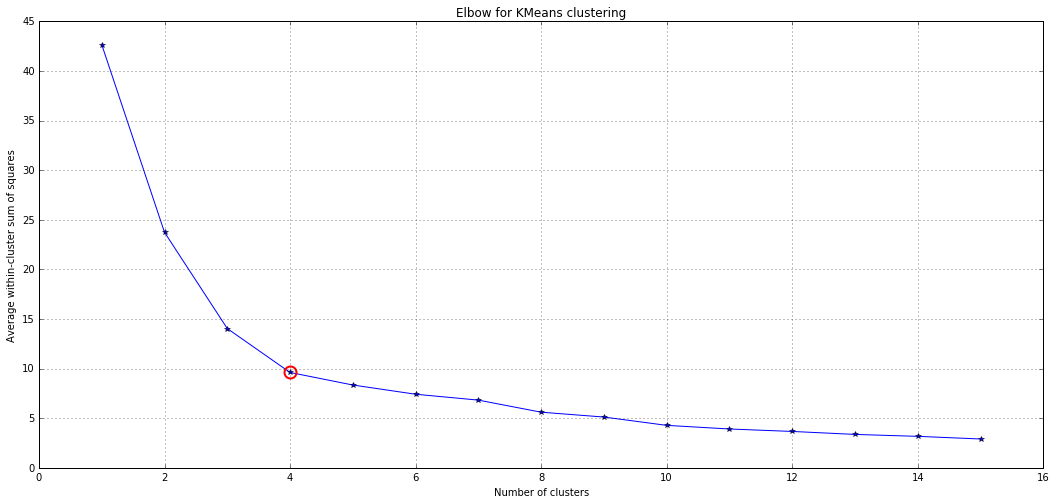

In [30]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
import math

data = summary_m[['frequency', 'recency']]

# Find the best k (clusters amount) using Elbow method
K = range(1,50)
KM = [KMeans(n_clusters=k).fit(data) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D, axis=1) for D in D_k]
dist = [np.min(D, axis=1) for D in D_k]
wsse = [sum(d)/data.shape[0] for d in dist]

last_angle = np.pi
max_diff = 0.0
bestK = 1
for i in range(1, len(wsse)-2):
    v0 = wsse[i-1] - wsse[i]
    v1 = wsse[i+1] - wsse[i]
    angle = np.arccos( (-1 + v0*v1) / (math.sqrt(1 + math.pow(v0, 2))) / (math.sqrt(1 + math.pow(v1, 2))) )
    diff = angle - last_angle
    if diff > max_diff: 
        max_diff = diff; 
        bestK = i
    last_angle = angle;
print "bestK:", bestK

# Elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K[:15], wsse[:15], 'b*-')
ax.plot(K[bestK-1], wsse[bestK-1], marker='o', markersize=12, markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

Above plot need to understand above code and its results

In [31]:
model = KMeans(n_clusters=bestK).fit(data)
print "Values of frequency and recency for some category"
print model.cluster_centers_

# Here each number corresponds to some category
print list(model.labels_)

Values of frequency and recency for some category
[[ 14.61538462  39.07692308]
 [ 71.71428571  88.85714286]
 [  1.375        2.0625    ]
 [ 20.15384615  79.23076923]]
[1, 1, 2, 2, 1, 3, 0, 3, 2, 3, 0, 0, 3, 1, 1, 2, 2, 3, 2, 2, 3, 1, 3, 3, 0, 0, 0, 2, 1, 2, 0, 1, 3, 1, 1, 0, 0, 2, 3, 1, 2, 3, 2, 2, 2, 1, 1, 0, 2, 2, 0, 3, 0, 0, 1, 3]


In [32]:
summary_m_clusters = summary_m.copy()
summary_m_clusters['category'] = model.labels_
summary_m_clusters.head(10)

,frequency,recency,T,monetary_value,category
AccountID,,,,,
1,75,94,95,49.266667,1
6,63,94,95,181.682540,1
8,1,1,88,270.000000,2
10,1,1,95,157.000000,2
11,70,78,79,240.400000,1
13,31,92,93,164.451613,3
14,3,26,95,285.333333,0
16,18,68,76,41.722222,3
17,2,2,95,14.500000,2


** What we see (for the case of 4 clusters):**

* There are 4 AccountID groups: 
    * 0 - with moderate values of frequency	and recency
    * 1 - with high values of frequency	and recency
    * 2 - with too low values of frequency and recency
    * 3 - with low (or moderate) frequency but with high recency
    
Count AccountIDs amount for each category

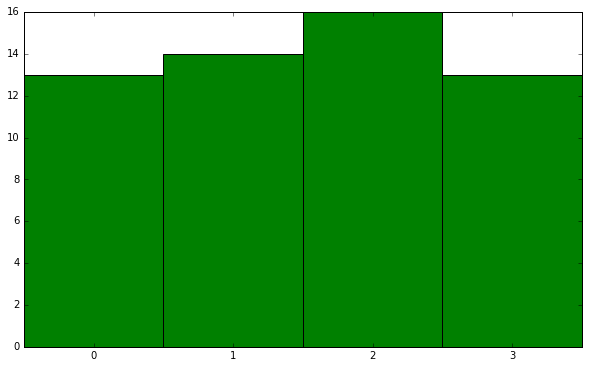

In [33]:
amount = [summary_m_clusters[summary_m_clusters['category'] == i]['T'].count() for i in range(bestK)]
ind = np.arange(bestK)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(ind-0.5, amount, width=1, color='g')
ax.set_xticks(ind)
ax.set_xticklabels(range(bestK))
plt.show()

# 5. Churn prediction (first steps)

In [34]:
# To run the below block you need install graphLab-Create. See https://dato.com/products/create/

import graphlab as gl
from dateutil import parser

sf = gl.SFrame(df)
sf['TransitionDate'] = sf.apply(lambda x: datetime.datetime.strptime(str(int(x['TransitionYear'])) + str(int(x['TransitionMonth'])) + '1', "%Y%m%d").date())
sf = sf.remove_columns(['TransitionYear', 'TransitionMonth'])
sf = sf.fillna('Value', 0)
sf = sf[sf['Value'] != 0]
sf['AccountID'] = sf['AccountID'].apply(lambda x: int(x))
sf.head(5)

A newer version of GraphLab Create (v1.10.1) is available! Your current version is v1.9.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.
2016-06-28 19:58:01,701 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.9 started. Logging: /tmp/graphlab_server_1467133079.log


This non-commercial license of GraphLab Create is assigned to rospotnyk@gmail.com and will expire on May 20, 2017. For commercial licensing options, visit https://dato.com/buy/.


AccountID,Industry,Value,TransitionDate
1,Other,8.0,2008-07-01 00:00:00
1,Other,4.0,2008-08-01 00:00:00
1,Other,1.0,2008-10-01 00:00:00
1,Other,1.0,2008-12-01 00:00:00
1,Other,2.0,2009-02-01 00:00:00


In [35]:
# Convert the SFrame into TimeSeries with TransitionDate as the index.
time_series = gl.TimeSeries(sf, 'TransitionDate')
time_series.head(5)

TransitionDate,AccountID,Industry,Value
2008-07-01 00:00:00,1,Other,8.0
2008-07-01 00:00:00,6,S,41.0
2008-07-01 00:00:00,10,Other,49.0
2008-07-01 00:00:00,14,S,2.0
2008-07-01 00:00:00,17,EO,1.0


In [36]:
# Split the data using the special train, validation split. 
train, valid = gl.churn_predictor.random_split(time_series, user_id='AccountID', fraction=0.9)

# Define the period of in-activity that constitutes churn. 
# Here we run algorithm for month's distribution
churn_period = datetime.timedelta(days = 30)

# Train a churn prediction model.
model = gl.churn_predictor.create(train, user_id='AccountID', features = ['Value'], churn_period = churn_period)

predictions = model.predict(time_series)

PROGRESS: Grouping observation_data by user.
PROGRESS: Resampling grouped observation_data by time-period 1 day, 0:00:00.
PROGRESS: No time boundaries specified, computing 10 boundaries from 2008-07-01 00:00:00 to 2016-05-01 00:00:00
PROGRESS: Generating features for time-boundary.
PROGRESS: --------------------------------------------------
PROGRESS: Features for 2009-04-13 05:24:00.
PROGRESS: Features for 2010-01-24 06:48:00.
PROGRESS: Features for 2010-11-06 09:12:00.
PROGRESS: Features for 2011-08-19 12:36:00.
PROGRESS: Features for 2012-05-31 15:00:00.
PROGRESS: Features for 2013-03-13 16:24:00.
PROGRESS: Features for 2013-12-24 18:48:00.
PROGRESS: Features for 2014-10-06 22:12:00.
PROGRESS: Features for 2015-07-20 00:36:00.
PROGRESS: Training a classifier model.

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 433

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 119

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.002687     | 0.919169          | 0.524542          |

| 2         | 0.085542     | 0.919169          | 0.424528          |

| 3         | 0.092799     | 0.921478          | 0.361947          |

| 4         | 0.099386     | 0.912240          | 0.318678          |

| 5         | 0.102240     | 0.916859          | 0.285964          |

| 6         | 0.115725     | 0.928406          | 0.262638          |

+-----------+--------------+-------------------+-------------------+


PROGRESS: --------------------------------------------------
PROGRESS: Model training complete: Next steps
PROGRESS: --------------------------------------------------
PROGRESS: (1) Evaluate the model at various timestamps in the past:
PROGRESS:       metrics = model.evaluate(data, time_in_past)
PROGRESS: (2) Make a churn forecast for a timestamp in the future:
PROGRESS:       predictions = model.predict(data, time_in_future)
PROGRESS: Making a churn forecast for the time window:
PROGRESS: --------------------------------------------------
PROGRESS:  Start : 2016-05-01 00:00:00
PROGRESS:  End   : 2016-05-31 00:00:00
PROGRESS: --------------------------------------------------
PROGRESS: Grouping dataset by user.
PROGRESS: Resampling grouped observation_data by time-period 1 day, 0:00:00.
PROGRESS: Generating features for boundary 2016-05-01 00:00:00.


The probability that a consumer will be not active in the nearest 30 days (we select 30 days before)

In [37]:
predictions

AccountID,probability
1,0.21917155385
6,0.165198639035
8,0.952323019505
10,0.952323019505
11,0.141367644072
13,0.0716117843986
14,0.961969316006
16,0.91025274992
17,0.952323019505
19,0.225544884801


Similar predictions for a half of a year

In [38]:
# Split the data using the special train, validation split. 
train, valid = gl.churn_predictor.random_split(time_series, user_id='AccountID', fraction=0.9)

# Define the period of in-activity that constitutes churn. 
churn_period = datetime.timedelta(days = 180)

# Train a churn prediction model.
model = gl.churn_predictor.create(train, user_id='AccountID', features = ['Value'], churn_period = churn_period)

predictions = model.predict(time_series)

PROGRESS: Grouping observation_data by user.
PROGRESS: Resampling grouped observation_data by time-period 1 day, 0:00:00.
PROGRESS: No time boundaries specified, computing 10 boundaries from 2008-07-01 00:00:00 to 2016-05-01 00:00:00
PROGRESS: Generating features for time-boundary.
PROGRESS: --------------------------------------------------
PROGRESS: Features for 2009-04-13 05:24:00.
PROGRESS: Features for 2010-01-24 06:48:00.
PROGRESS: Features for 2010-11-06 09:12:00.
PROGRESS: Features for 2011-08-19 12:36:00.
PROGRESS: Features for 2012-05-31 15:00:00.
PROGRESS: Features for 2013-03-13 16:24:00.
PROGRESS: Features for 2013-12-24 18:48:00.
PROGRESS: Features for 2014-10-06 22:12:00.
PROGRESS: Features for 2015-07-20 00:36:00.
PROGRESS: Training a classifier model.

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 398

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 119

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.000997     | 0.881910          | 0.536926          |

| 2         | 0.001951     | 0.874372          | 0.445832          |

| 3         | 0.022952     | 0.879397          | 0.388631          |

| 4         | 0.028790     | 0.886935          | 0.346167          |

| 5         | 0.039450     | 0.889447          | 0.315473          |

| 6         | 0.049846     | 0.886935          | 0.293598          |

+-----------+--------------+-------------------+-------------------+


PROGRESS: --------------------------------------------------
PROGRESS: Model training complete: Next steps
PROGRESS: --------------------------------------------------
PROGRESS: (1) Evaluate the model at various timestamps in the past:
PROGRESS:       metrics = model.evaluate(data, time_in_past)
PROGRESS: (2) Make a churn forecast for a timestamp in the future:
PROGRESS:       predictions = model.predict(data, time_in_future)
PROGRESS: Making a churn forecast for the time window:
PROGRESS: --------------------------------------------------
PROGRESS:  Start : 2016-05-01 00:00:00
PROGRESS:  End   : 2016-10-28 00:00:00
PROGRESS: --------------------------------------------------
PROGRESS: Grouping dataset by user.
PROGRESS: Resampling grouped observation_data by time-period 1 day, 0:00:00.
PROGRESS: Generating features for boundary 2016-05-01 00:00:00.


In [39]:
predictions

AccountID,probability
1,0.0396526828408
6,0.0381362736225
8,0.942130148411
10,0.942130148411
11,0.0727698281407
13,0.0345226414502
14,0.959321796894
16,0.373547583818
17,0.942130148411
19,0.276469230652


In [ ]:
# TODO:
# LTV calculation based on churn predictions

$$LTV = (Avg. Monthly Subscription Payment \times Gross Margin IN \%) / Churn Rate$$

http://smallbusiness.chron.com/calculate-gross-profit-margin-percentage-4133.html